In [1]:
# Main libraries for implementation and visualization
import numpy as np
import matplotlib.pyplot as plt
# Functions for data generation and splitting into train and test
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [2]:
X, y = make_blobs(n_samples=500, centers=3, cluster_std=0.90, random_state=0)

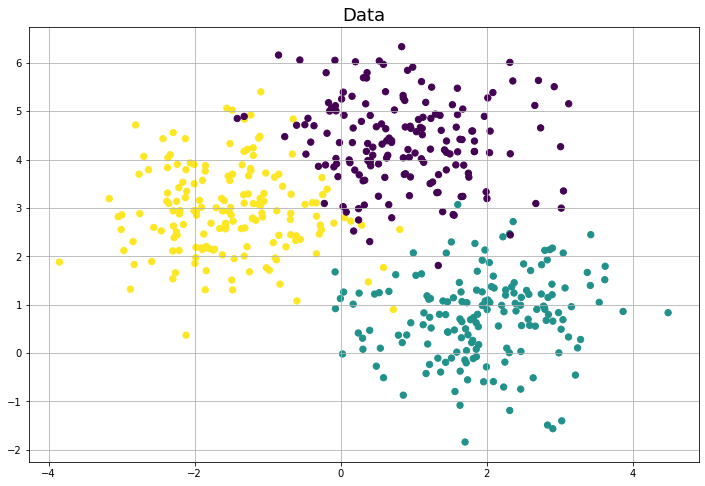

In [3]:
plt.figure(figsize=(12, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap="viridis")
plt.grid()
plt.title("Data", fontsize=18)
plt.show()

## Implementation of the logistic regression class

In [4]:
class LogisticMulticlass:
    def __init__(self, lr=0.02, max_iter=1000, C=None):
        if C is not None:
            self.C = C
        else:
            self.C = float("inf")
        self.losses = np.array([])
        
    @staticmethod
    def _onehot(labels):
        """
        We want our model to work like a library one.
        Therefore, the target variable must be one-dimensional.
        But in the implementation, we need the target variable in the form of one-hot.
        That is exactly what this function does.
        """
        dict_onehot = {key: value for value, key
                                           in enumerate(np.unique(labels))}
        labels_onehot = np.array(list(map(dict_onehot.get, labels)))
        result_onehot = np.squeeze(np.eye(len(dict_onehot))
                                               [labels_onehot.reshape(-1)])
        
        return result_onehot
    
    def _calc_probs(self, data_bias):
        probs = (np.exp(-np.dot(data_bias, self.w)).T /
                     np.sum(np.exp(-np.dot(data_bias, self.w)), axis=1)).T
        
        return probs
    
    def _calc_loss(self, data_bias, labels_encoded):
        loss = np.trace(
            np.dot(data_bias, np.dot(self.w,np.transpose(labels_encoded)))
        ) \
        + np.sum(np.log(np.sum(np.exp(np.dot(-data_bias, self.w)), axis=1)))
        
        return loss
    
    def _calc_grad(self, data_bias, labels_encoded, probabilities):
        grad = ( np.dot(np.transpose(data_bias),
                        labels_encoded -  probabilities) /
                len(data_bias) +  self.w / self.C / len(data_bias))
        
        return grad
        
    
    def fit(self, data, labels, lr=0.02, max_iter=1000):
        """
        This function trains the model through gradient descent.
        """
        labels_encoded = self._onehot(labels)
        data_bias = np.concatenate((data, np.ones((len(data), 1))), axis = 1)
    
        self.w = np.random.randn(np.size(data, 1) + 1,
                                 np.size(labels_encoded, 1))
        # Training loop
        for i in range(max_iter):
            probs = self._calc_probs(data_bias) # calculating probabilities    
            
            loss = self._calc_loss(data_bias, labels_encoded) # calculating loss
            
            grad = self._calc_grad(data_bias, labels_encoded, probs) # calculating gradients
            
            self.w += -lr * grad # updating model parameters
            
            self.losses = np.append(self.losses, loss)
            
    
    def predict(self, data):
        """
        This function makes predictions.
        """
        data_bias = np.concatenate((data, np.ones((len(data), 1))), axis = 1)
        
        probs = (np.exp(-np.dot(data_bias, self.w)).T /
             np.sum(np.exp(-np.dot(data_bias, self.w)), axis=1)).T
        labels_pred = probs.argmax(axis=1)
        
        return labels_pred

## Experiments

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [6]:
# Without regularization
logistic_casual = LogisticMulticlass()
logistic_casual.fit(X_train, y_train)
L_casual = logistic_casual.losses
# With regularization
logistic_l2 = LogisticMulticlass(C=0.001)
logistic_l2.fit(X_train, y_train)
L_l2 = logistic_l2.losses

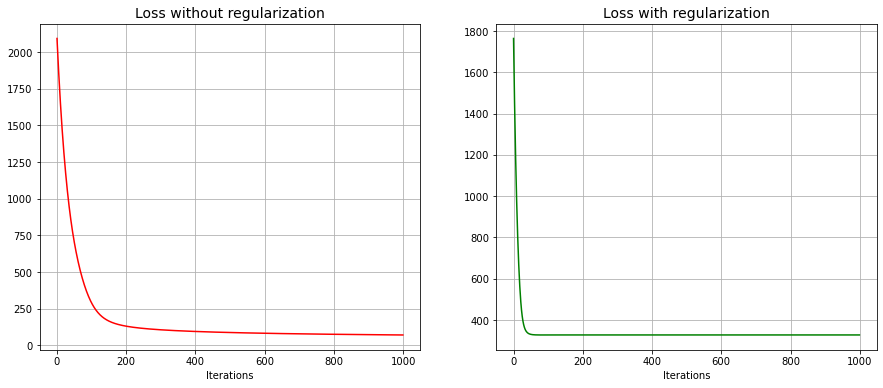

In [7]:
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.grid()
plt.xlabel("Iterations")
plt.title("Loss without regularization", fontsize=14)
plt.plot(range(len(L_casual[0:1000])), L_casual[0:1000], color="red")

plt.subplot(122)
plt.grid()
plt.xlabel("Iterations")
plt.title("Loss with regularization", fontsize=14)
plt.plot(range(len(L_l2[0:1000])), L_l2[0:1000], color="green")

plt.show()

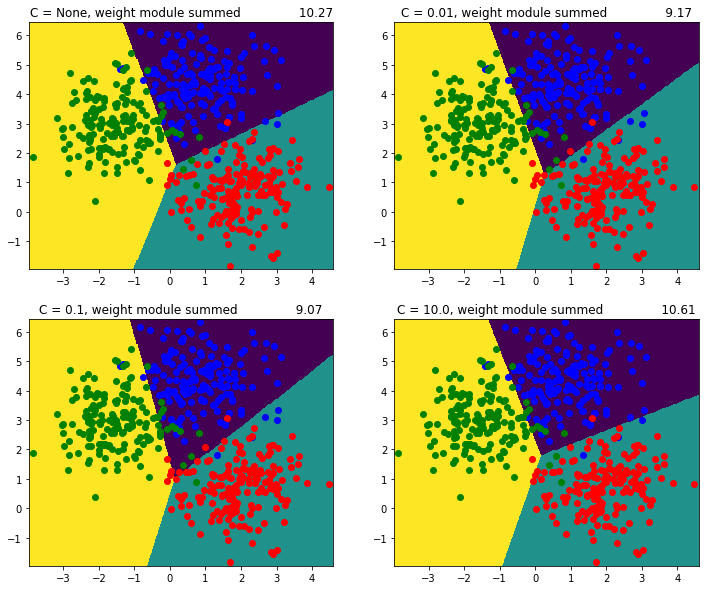

In [8]:
plt.figure(figsize=(12, 10))
C = [None, 0.01, 0.1, 10.0]
for i in range(len(C)):
    logistic = LogisticMulticlass(C[i])
    logistic.fit(X_train, y_train)
    
    eps = 0.1
    xx, yy = np.meshgrid(np.linspace(np.min(X_train[:,0]) - eps,
                                     np.max(X_train[:,0]) + eps, 300),
                     np.linspace(np.min(X_train[:,1]) - eps,
                                 np.max(X_train[:,1]) + eps, 300))
    
    preds = logistic.predict(np.stack([xx.reshape(-1),
                                       yy.reshape(-1)], axis=1))
    
    preds = preds.reshape(xx.shape)
    
    w_flatten = logistic.w
    
    plt.subplot(221 + i)
    plt.title(f"C = {C[i]}, weight module summed \
              {round(np.sum(np.abs(w_flatten)), 2)}")
    
    plt.pcolormesh(xx, yy, preds)
    
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ob")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "or")
    plt.plot(X[:, 0][y==2], X[:, 1][y==2], "og")
    
plt.show()

## Comparing with the sklearn

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [10]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_sklearn = clf.predict(X_test)
print(f"Test accuracy of sklearn: {accuracy_score(y_test, y_pred_sklearn)}")

Test accuracy of sklearn: 0.95


In [11]:
clf = LogisticMulticlass()
clf.fit(X_train, y_train)
y_pred_my = clf.predict(X_test)
print(f"Test accuracy of our model: {accuracy_score(y_test, y_pred_my)}")

Test accuracy of our model: 0.95


In [12]:
# We see that our model shows a good result. Of course, for a full-fledged
# comparison, one need to train it on larger data, but our goal was to 
# implement logistic regression on numpy.